In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pymc
%matplotlib inline

/home/kyohei/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
data = pd.read_csv('data7a.csv')

In [3]:
data.y.describe()

count    100.000000
mean       4.030000
std        3.150934
min        0.000000
25%        1.000000
50%        4.000000
75%        7.000000
max        8.000000
Name: y, dtype: float64

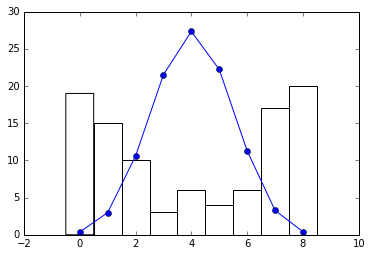

In [4]:
plt.hist(data.y,bins=np.linspace(-0.5,8.5,10),color='white')
plt.plot(np.linspace(0,8,9),scipy.stats.binom.pmf(np.linspace(0,8,9),8,0.504)*100,'o-')
plt.show()

In [5]:
Y = data.y
N = len(Y)
s = pymc.Uniform(name='s',lower=0,upper = 1.0e+4,value=0.01)
b = pymc.Normal(name='b', mu=0.0, tau=1.0e+2)

r = [pymc.Normal(name='r_{0}'.format(i),mu=0,tau=s**(-2)) for i in range(N)]
p = pymc.Lambda('p',lambda r = r,b=b:pymc.invlogit(b+r))

obs = pymc.Binomial(name='obs',n=8,p=p,value=Y,observed=True)
model = pymc.Model([b,s,obs])

In [6]:
mcmc = pymc.MCMC(model)
mcmc.sample(iter=10000,burn=1000,thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 222.0 sec

In [25]:
p.value

array([  4.38311516e-02,   2.85295247e-01,   9.77557409e-01,
         9.83236289e-01,   7.32465831e-02,   9.33216490e-01,
         9.97030848e-01,   9.92668858e-01,   2.58824169e-01,
         6.36759055e-02,   4.41843958e-01,   7.39110827e-02,
         1.40479446e-02,   5.24031031e-01,   7.72670412e-01,
         9.57662806e-01,   8.71578098e-01,   1.12580301e-01,
         1.69743412e-01,   2.23520677e-01,   1.32362852e-01,
         8.74560292e-02,   7.32917631e-01,   8.70181648e-01,
         9.89523932e-01,   2.32410524e-01,   9.34988573e-01,
         5.92906453e-01,   3.48529214e-01,   2.11638069e-01,
         9.21857176e-01,   9.40766979e-01,   9.94875800e-01,
         1.57312255e-04,   3.90776990e-01,   8.25456563e-01,
         8.54861158e-01,   9.54598841e-01,   1.18498245e-01,
         2.78726792e-01,   8.55215135e-02,   1.02615574e-02,
         7.69296607e-02,   9.25209601e-01,   9.61734438e-01,
         3.00093473e-01,   6.86001141e-01,   1.46016920e-01,
         9.89687933e-01,

Plotting b


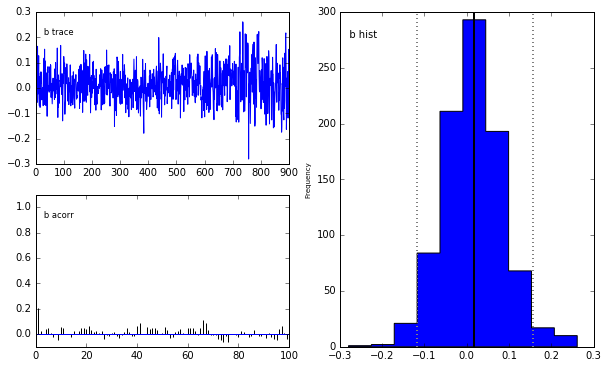

In [7]:
pymc.Matplot.plot(mcmc.trace('b'),common_scale=False)

Plotting s


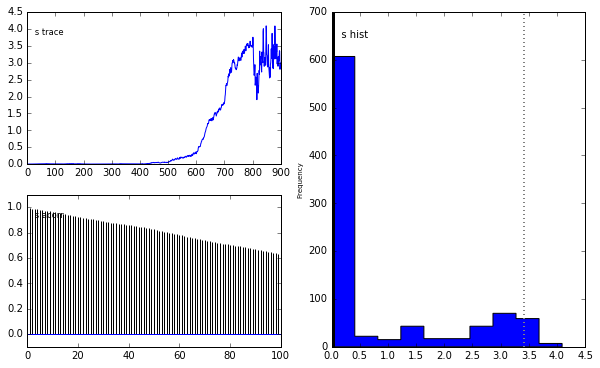

In [8]:
pymc.Matplot.plot(mcmc.trace('s'),common_scale=False)

Plotting r_0


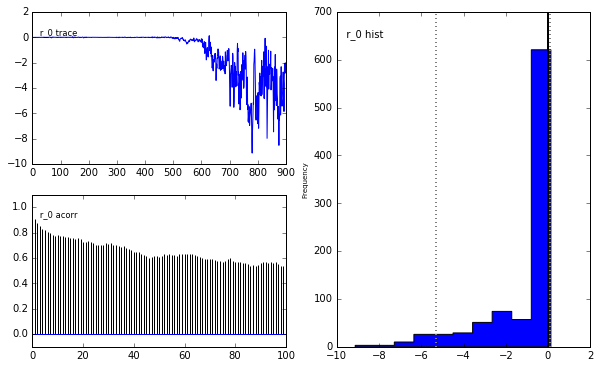

In [9]:
pymc.Matplot.plot(mcmc.trace('r_0'),common_scale=False)

In [10]:
left = 600

L = []
b_= np.mean(mcmc.trace('b')[left:])

for i in range(N):
    ri = np.mean(mcmc.trace('r_{0}'.format(i))[left:])
    L.append(pymc.binomial_expval(n=8,p=pymc.invlogit(b_+ri)))

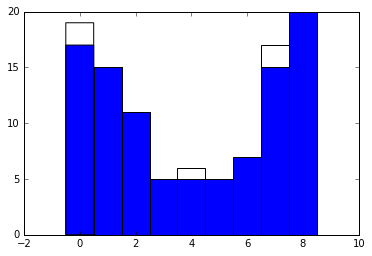

In [11]:
n_b, bins_b, pathces_b = plt.hist(data.y,bins=np.linspace(-0.5,8.5,10),color='white',label='before')
n_a, bins_a, pathces_a = plt.hist(L,bins=np.linspace(-0.5,8.5,10),color='blue',label='after')
plt.show()

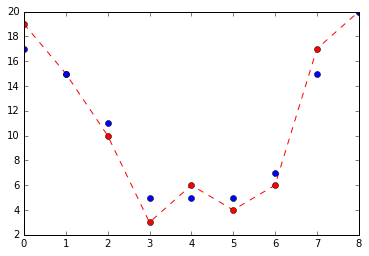

In [12]:
plt.plot(np.linspace(0,8,9),n_b,'ro--',label='before')
plt.plot(np.linspace(0,8,9),n_a,'bo',label='after')

In [13]:
np.linspace(0,8,9)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.])

(array([  1.,   7.,  21.,  56.,  95.,  54.,  39.,  19.,   7.,   1.]),
 array([-1.6788558 , -1.22319848, -0.76754117, -0.31188385,  0.14377346,
         0.59943077,  1.05508809,  1.5107454 ,  1.96640272,  2.42206003,
         2.87771734]),
 <a list of 10 Patch objects>)

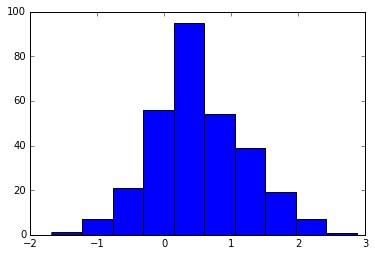

In [14]:
plt.hist(mcmc.trace('r_50')[left:])